In [1]:
import os
print(os.getcwd())

c:\Users\bryan\OneDrive - Université Libre de Bruxelles\Master 1 Ingénieur Civile\PROJ-H419 - Biomedical engineering project in image analysis - 202526


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, LGBMClassifier, log_evaluation, early_stopping
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, SVC
from sklearn.ensemble import AdaBoostRegressor, VotingClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from tqdm import tqdm
from colorama import Fore, Back, Style

from sklearn.metrics import log_loss
pd.set_option('display.max_columns', 500)

from fasteda import fast_eda
from openTSNE import TSNE

In [3]:
train = pd.read_csv("playground-series-s3e26/train.csv")
test = pd.read_csv("playground-series-s3e26/test.csv")
original = pd.read_csv("playground-series-s3e26/cirrhosis.csv")
sub = pd.read_csv("playground-series-s3e26/sample_submission.csv")

In [4]:
train["is_generated"] = 1
test["is_generated"] = 1
original["is_generated"] = 0

In [5]:
train.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_generated
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D,1
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C,1
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D,1
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C,1
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C,1


In [6]:
BOLD_TXT =  Style.BRIGHT
GREEN_TXT = BOLD_TXT + Fore.GREEN
RESET_TXT = Style.RESET_ALL

In [7]:
def preprocess(df):

    df["Drug"] = df["Drug"].map({"Placebo": 0, "D-penicillamine": 1})
    df["Sex"] = df["Sex"].map({"M": 0, "F": 1})
    
    for col in ["Ascites", "Hepatomegaly", "Spiders"]:
        df[col] = df[col].map({"N": 0, "Y": 1})
        
    df["Edema"] = df["Edema"].map({"N": 0, "S": 1, "Y": 1})
        
    return df

def scale_data(df):    
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[FEATURES])
    df[FEATURES] = scaled_data
    
    return df

In [8]:
for df in [train, test, original]:
    df = preprocess(df)
   # df = scale_data(df)

In [9]:
TARGET = "Status"
FEATURES = [col for col in train.columns if col not in ["id", TARGET]]

FEATURES

['N_Days',
 'Drug',
 'Age',
 'Sex',
 'Ascites',
 'Hepatomegaly',
 'Spiders',
 'Edema',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage',
 'is_generated']

In [10]:
train[TARGET] = train[TARGET].map({"D": 0, "CL": 1, "C": 2})
original[TARGET] = original[TARGET].map({"D": 0, "CL": 1, "C": 2})

In [11]:
TSNE_FEATURES = list(test.drop(columns = ["id", "is_generated"]))

train_tsne = train[TSNE_FEATURES].values
y_tsne = train["Status"].values

DataFrame Head:


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_generated
0,0,999,1,21532,0,0,0,0,0,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,0,1
1,1,2574,0,19237,1,0,0,0,0,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,2,1
2,2,3428,0,13727,1,0,1,1,1,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,0,1


DataFrame Tail:


,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,is_generated
7902,7902,1576,1,25873,1,0,0,1,1,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,0,1
7903,7903,3584,1,22960,0,0,1,0,0,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,0,1
7904,7904,1978,1,19237,1,0,0,0,0,0.7,256.0,3.23,22.0,645.0,74.40,85.0,336.0,10.3,3.0,2,1


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(7905, 21)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   int64  
 2   Drug           7905 non-null   int64  
 3   Age            7905 non-null   int64  
 4   Sex            7905 non-null   int64  
 5   Ascites        7905 non-null   int64  
 6   Hepatomegaly   7905 non-null   int64  
 7   Spiders        7905 non-null   int64  
 8   Edema          7905 non-null   int64  
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 

c:\Users\bryan\anaconda3\envs\PROJMAST1\Lib\site-packages\fasteda\__init__.py:76: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_ = df._get_numeric_data().dropna().apply(lambda x: skew(x)).to_frame(name = "skewness")
c:\Users\bryan\anaconda3\envs\PROJMAST1\Lib\site-packages\fasteda\__init__.py:77: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_ = df._get_numeric_data().dropna().apply(lambda x: kurtosis(x)).to_frame(name = "kurtosis")
c:\Users\bryan\anaconda3\envs\PROJMAST1\Lib\site-packages\fasteda\__init__.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_info.iloc[:,:-2] = full_info.iloc[:,:-2].applymap(lambda x: format(x, '.3f') \
c:\Users\bryan\anaconda3\envs\PROJMAST1\Lib\site-p

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
id,7905,3952,3952,2282.121,0,1976,3952,5928,7904,0.000000,-1.200000
N_Days,7905,2030.173,1831,1094.234,41,1230,1831,2689,4795,0.448575,-0.494464
Drug,7905,0.493,0,0.5,0,0,0,1,1,0.029099,-1.999153
Age,7905,18373.146,18713,3679.959,9598,15574,18713,20684,28650,0.084075,-0.497827
Sex,7905,0.928,1,0.258,0,1,1,1,1,-3.312153,8.970357
Ascites,7905,0.048,0,0.214,0,0,0,0,1,4.225296,15.853130
Hepatomegaly,7905,0.511,1,0.5,0,0,1,1,1,-0.045299,-1.997948
Spiders,7905,0.245,0,0.43,0,0,0,0,1,1.183998,-0.598148
Edema,7905,0.094,0,0.292,0,0,0,0,1,2.780089,5.728896
Bilirubin,7905,2.594,1.1,3.813,0.3,0.7,1.1,3,28,3.339062,12.899902


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



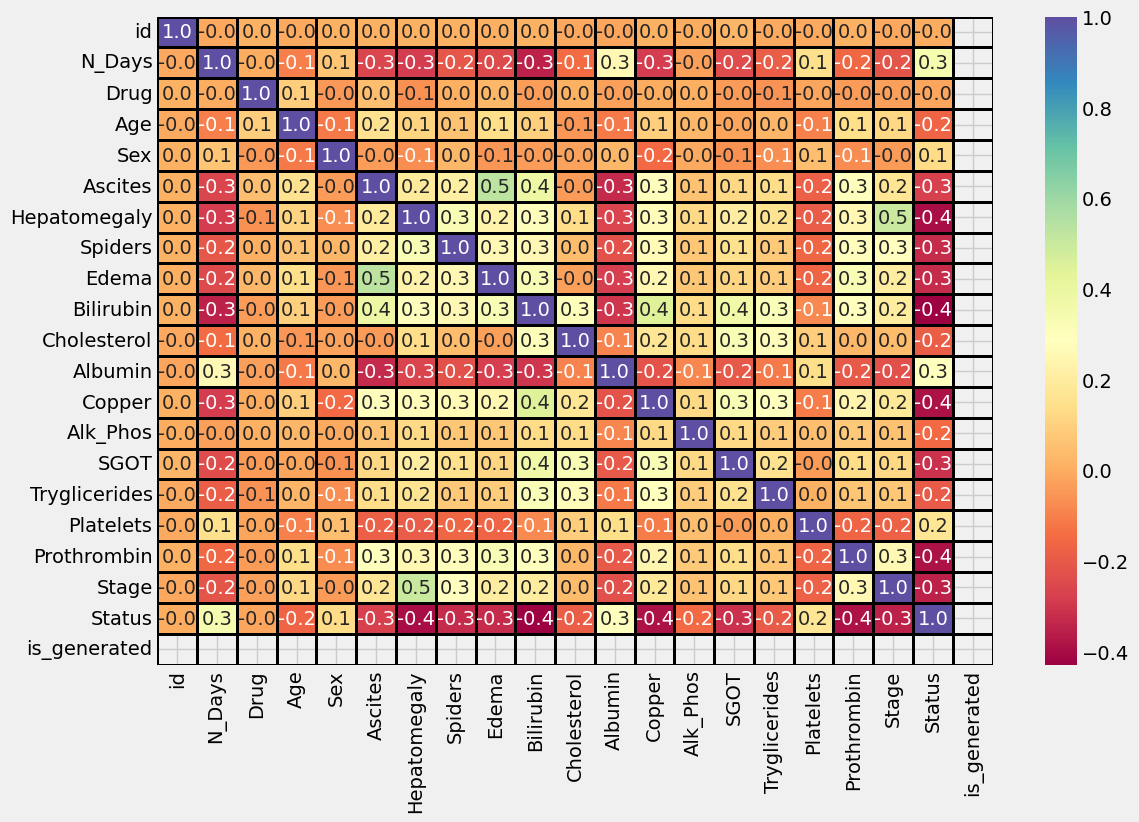

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



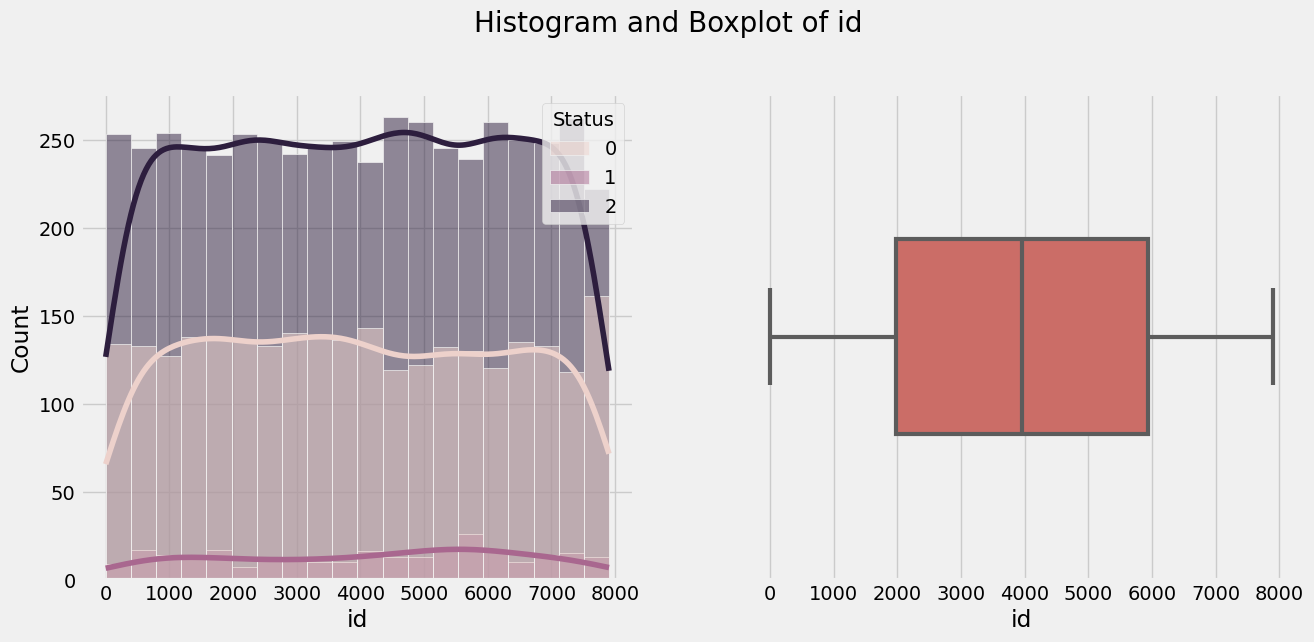

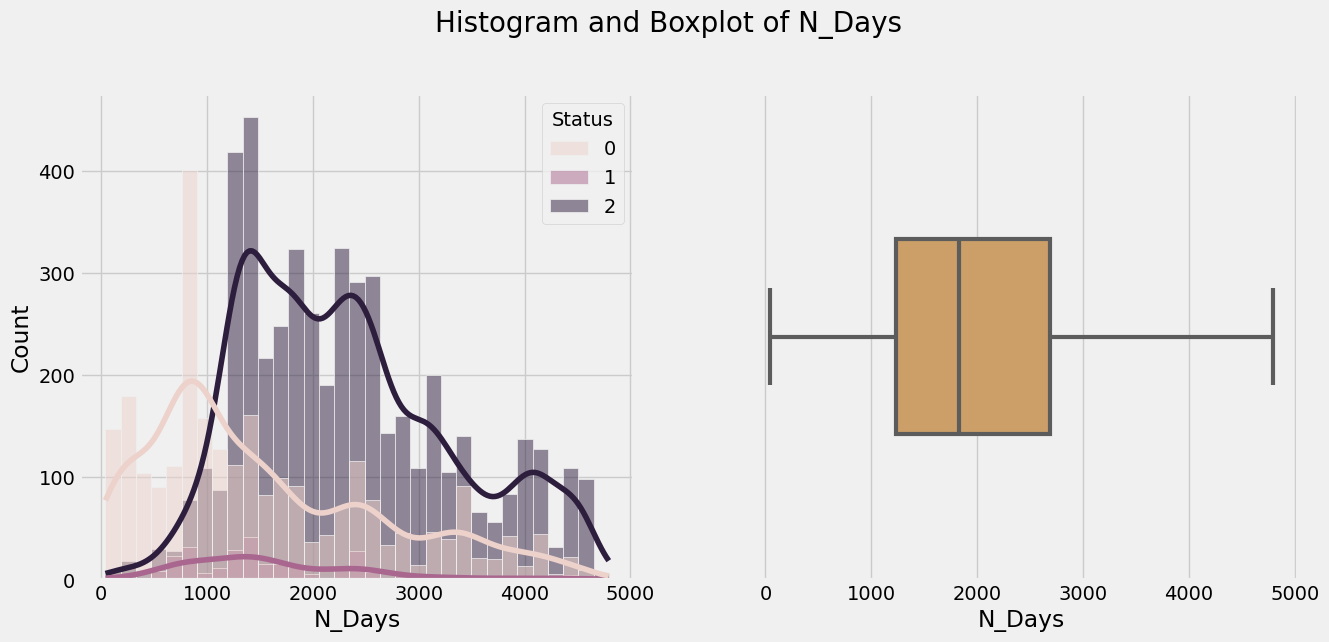

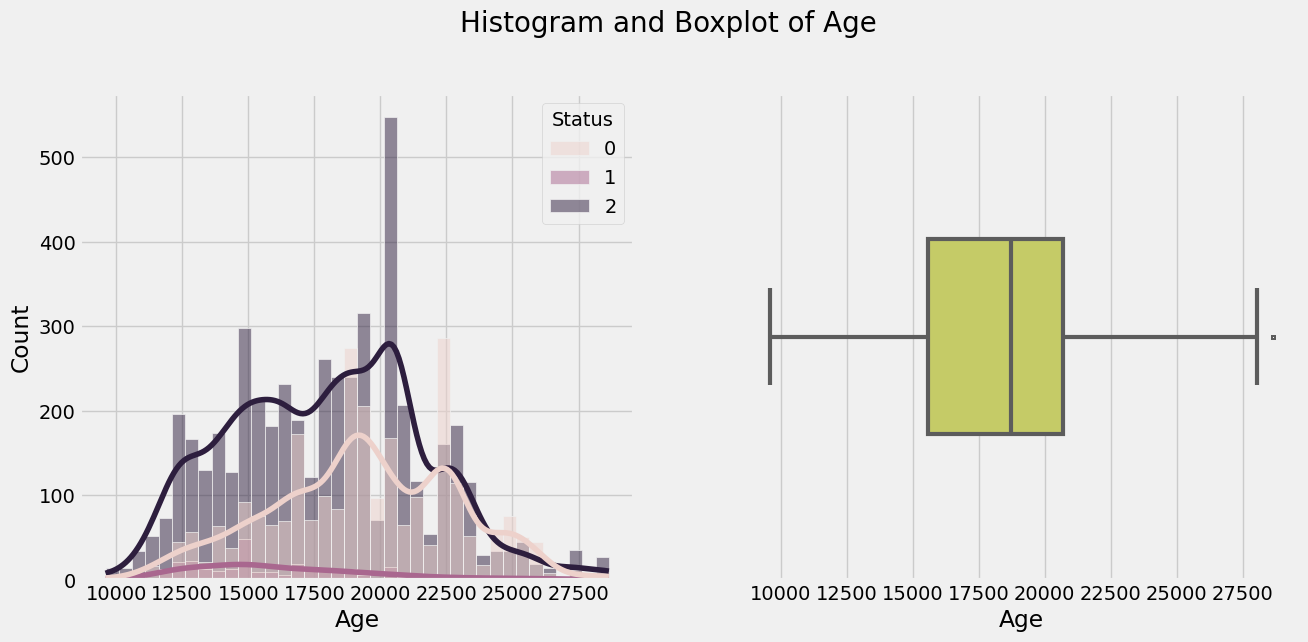

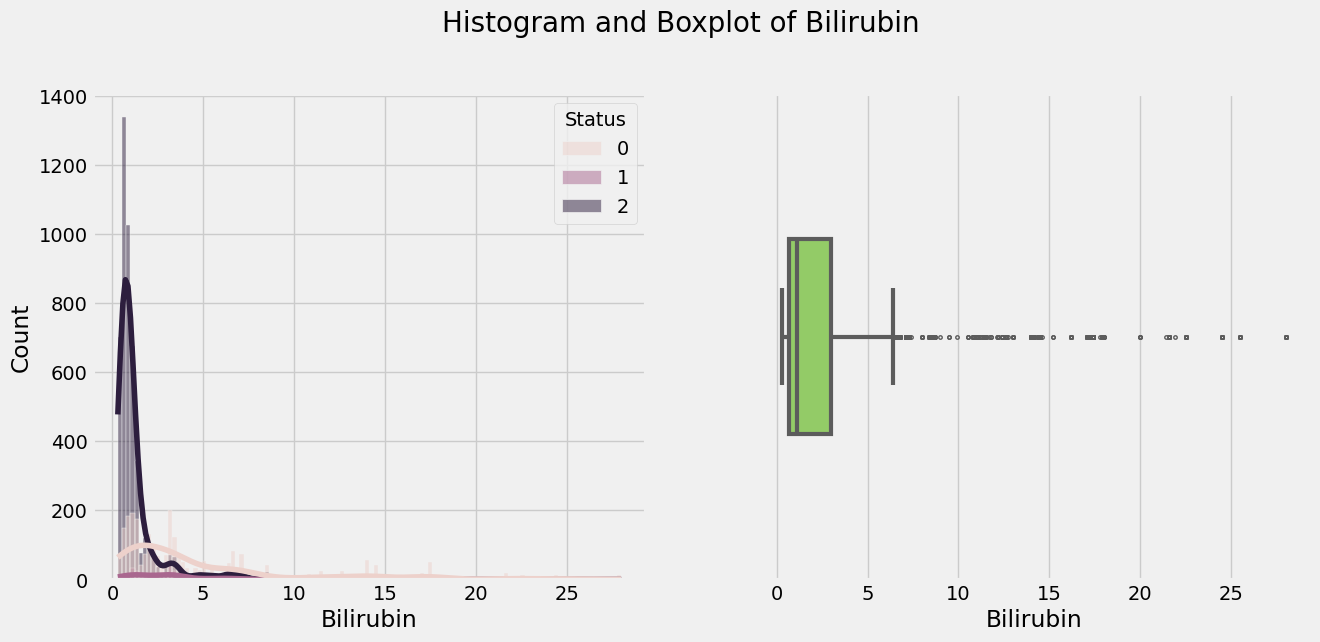

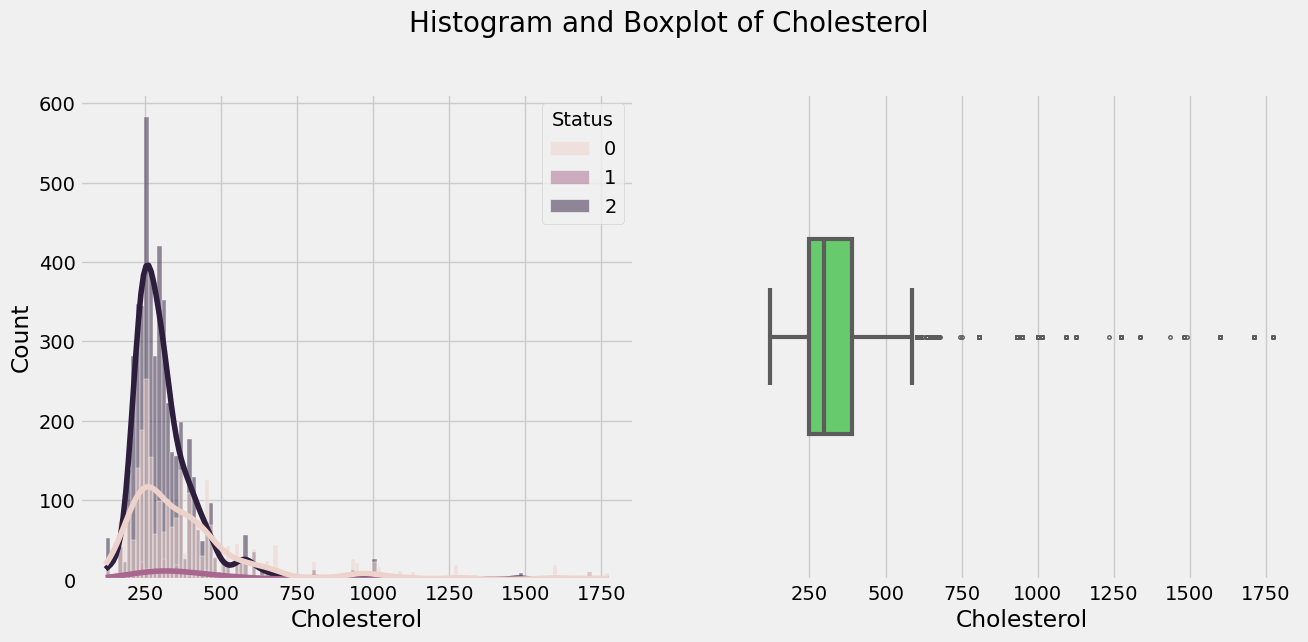

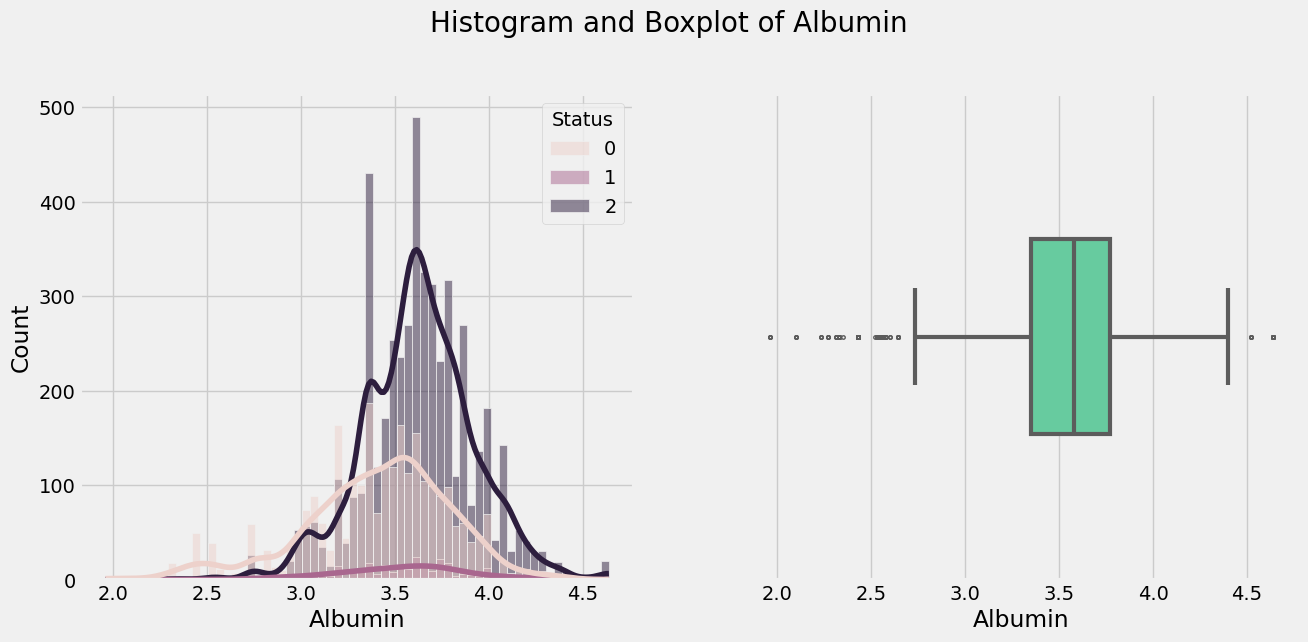

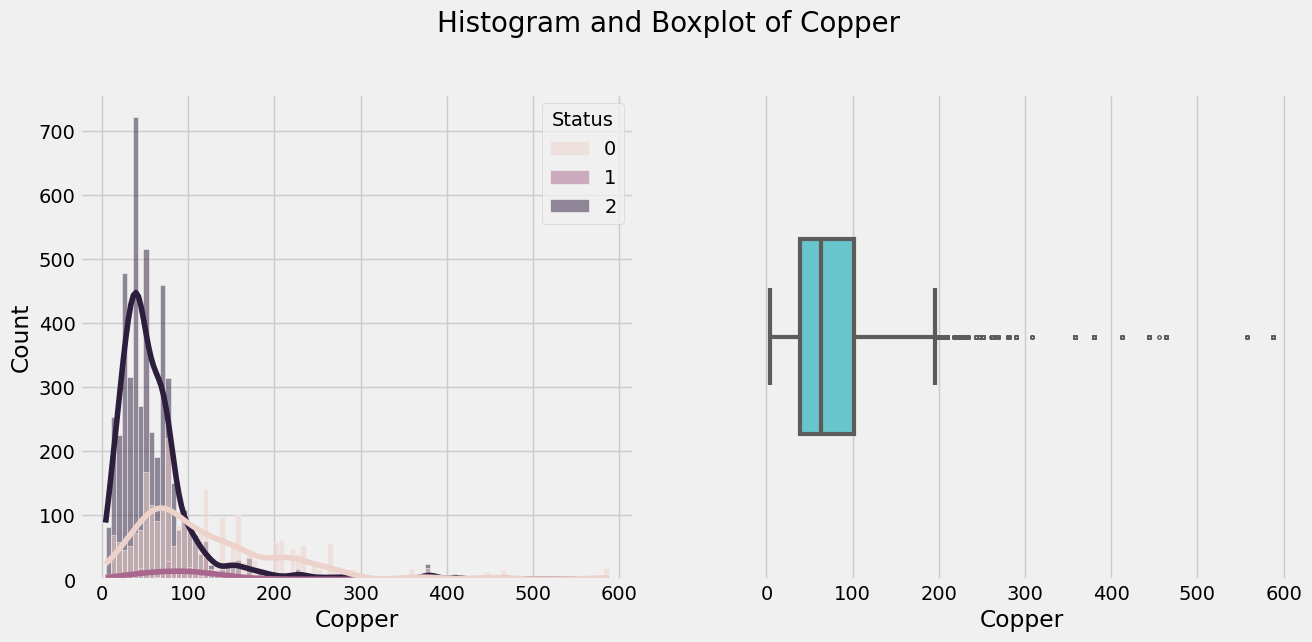

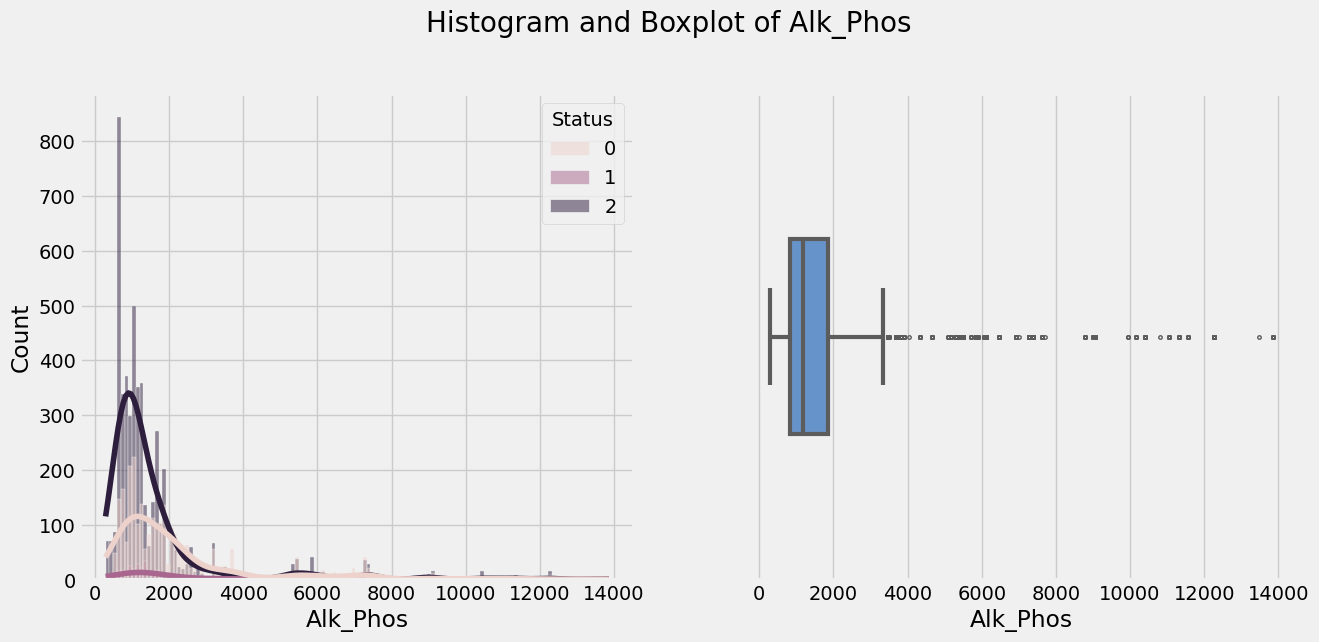

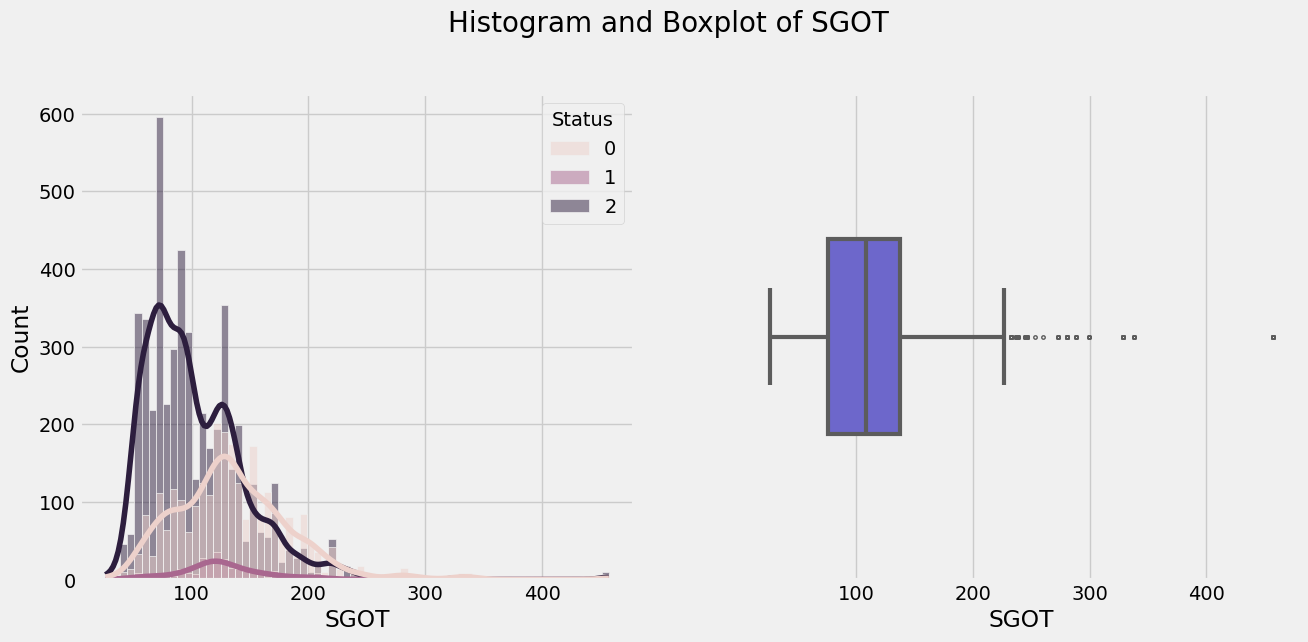

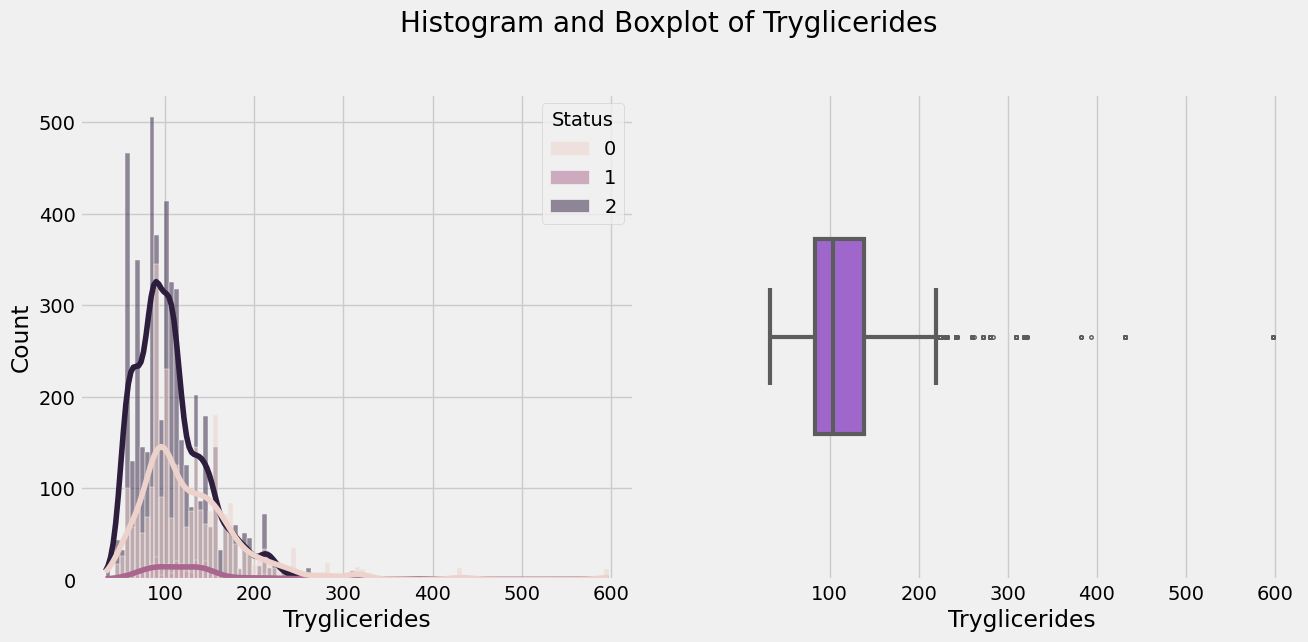

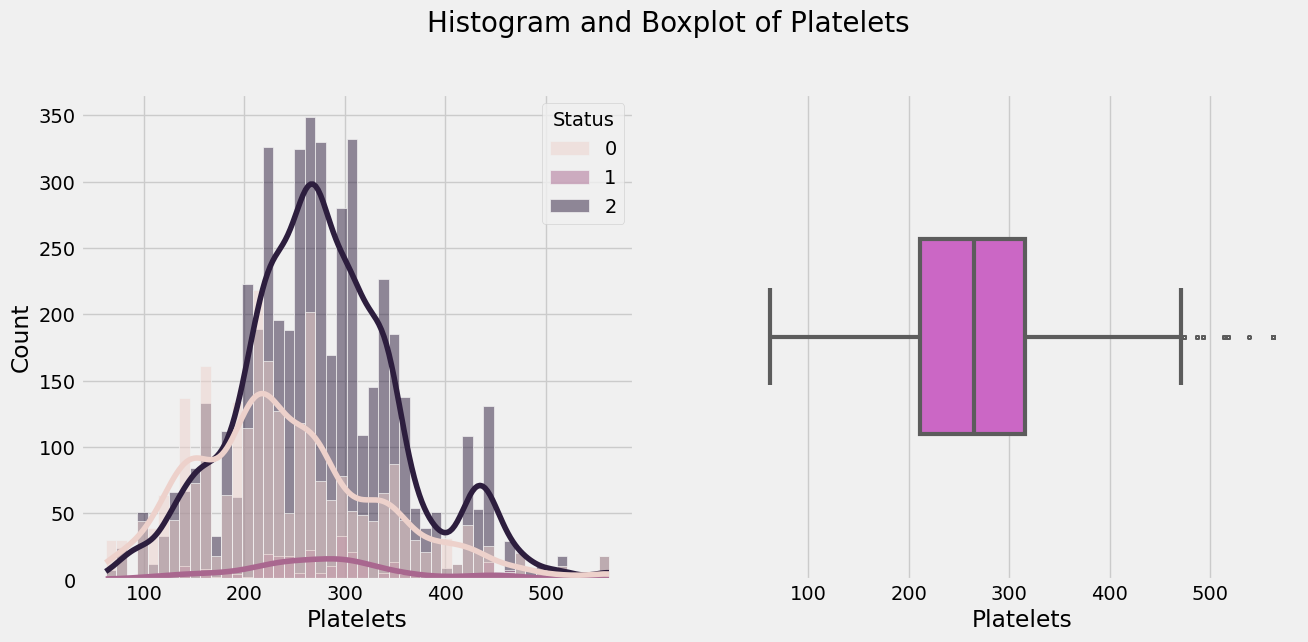

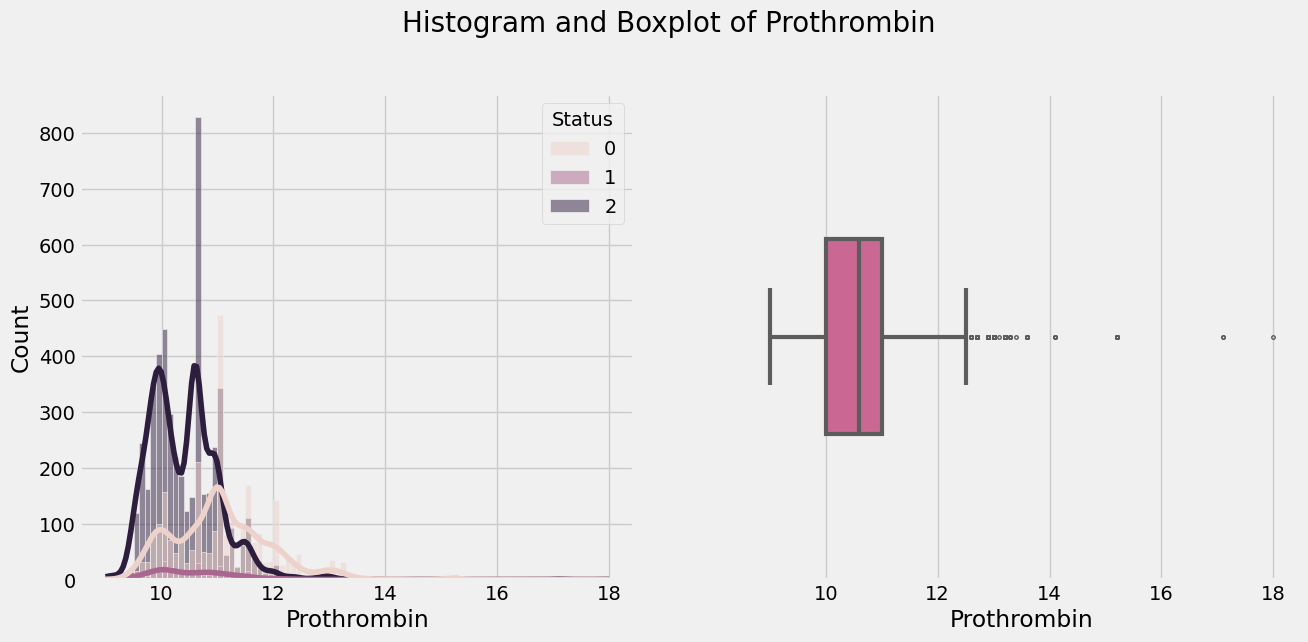

----------------------------------------------------------------------------------------------------
Countplot(s):



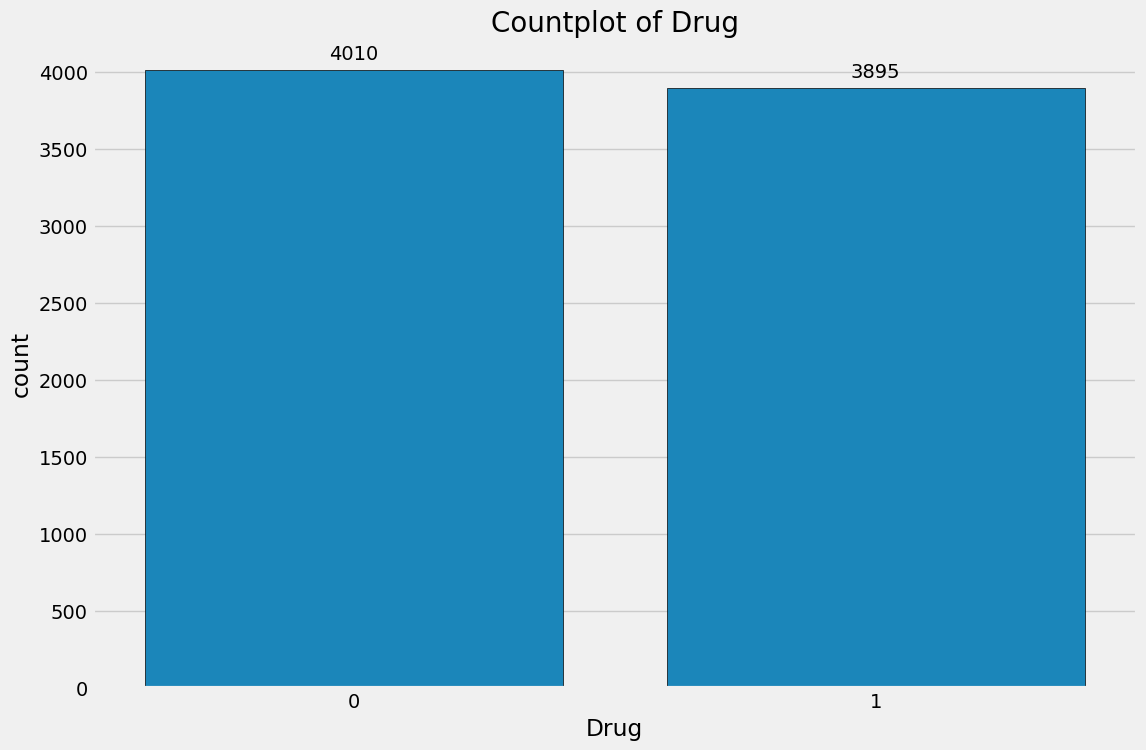

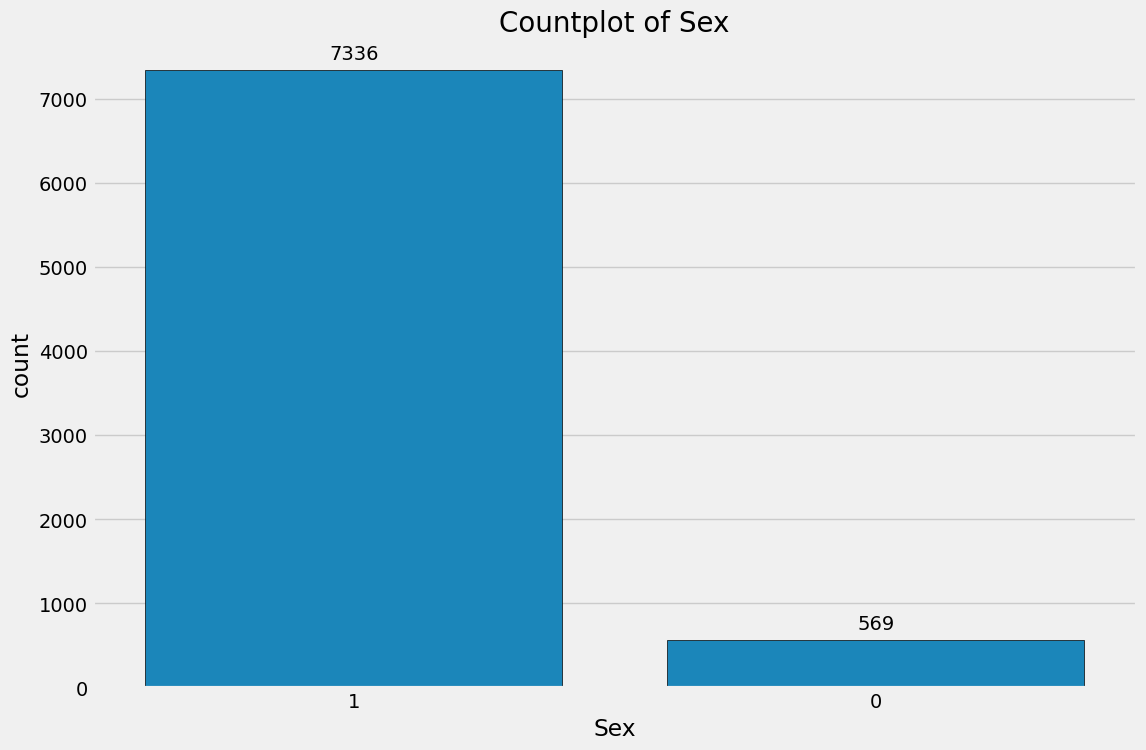

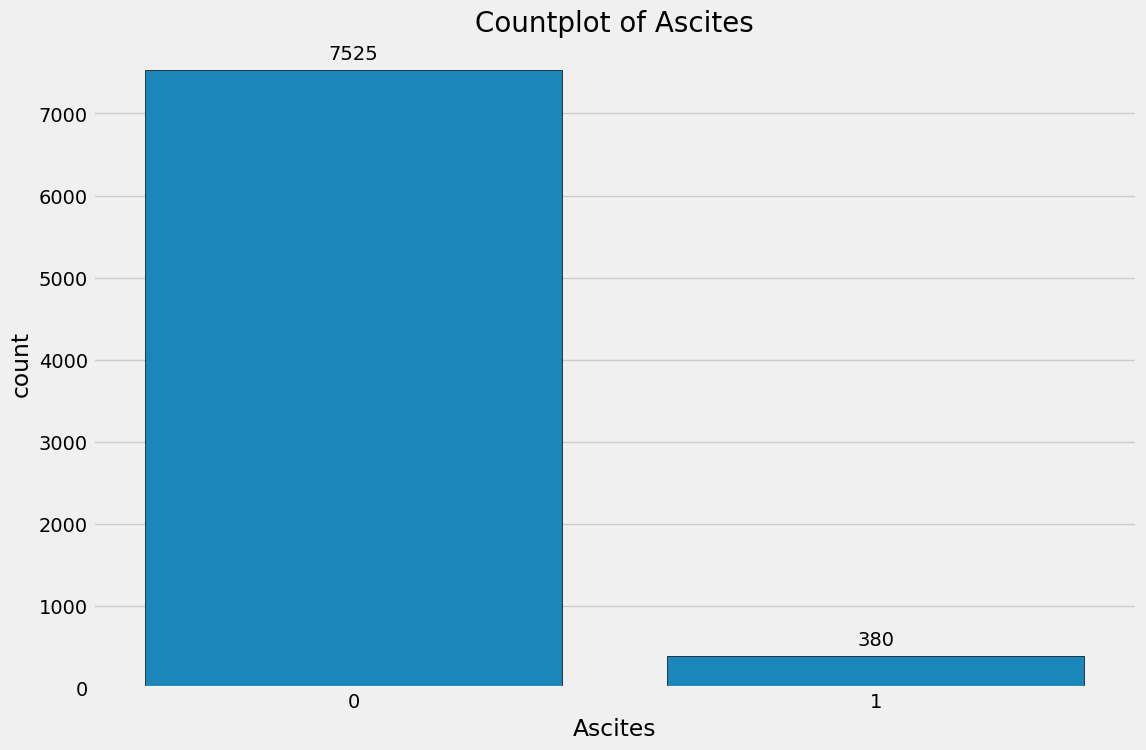

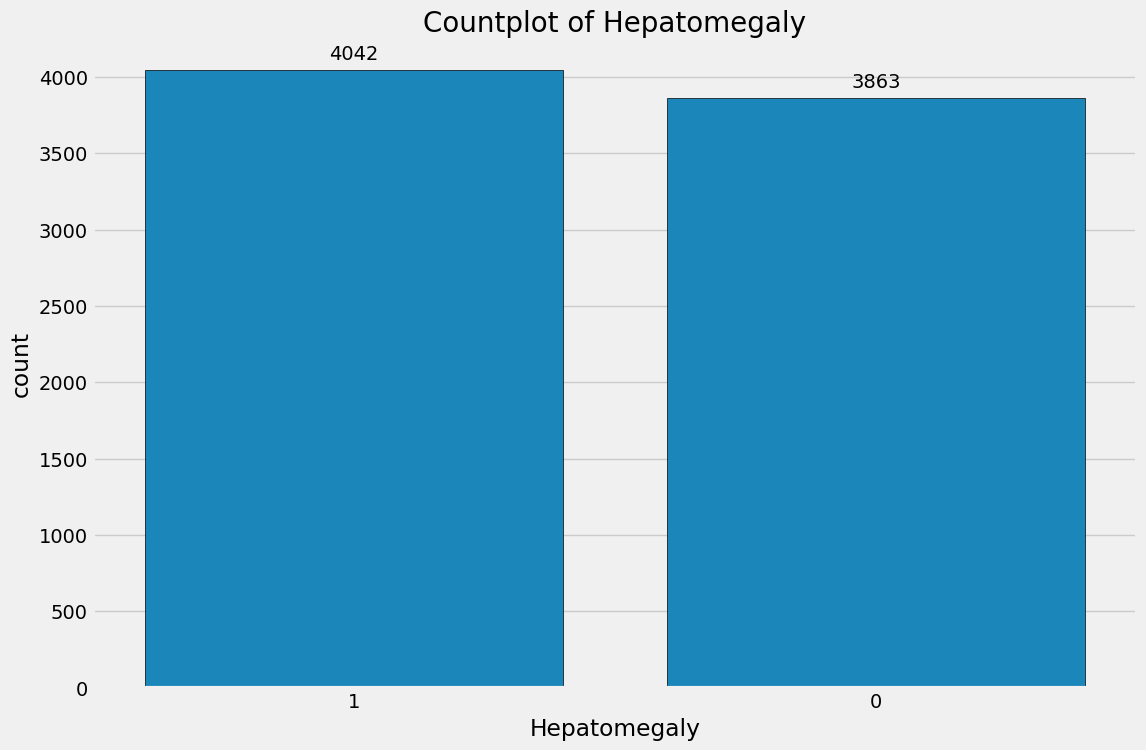

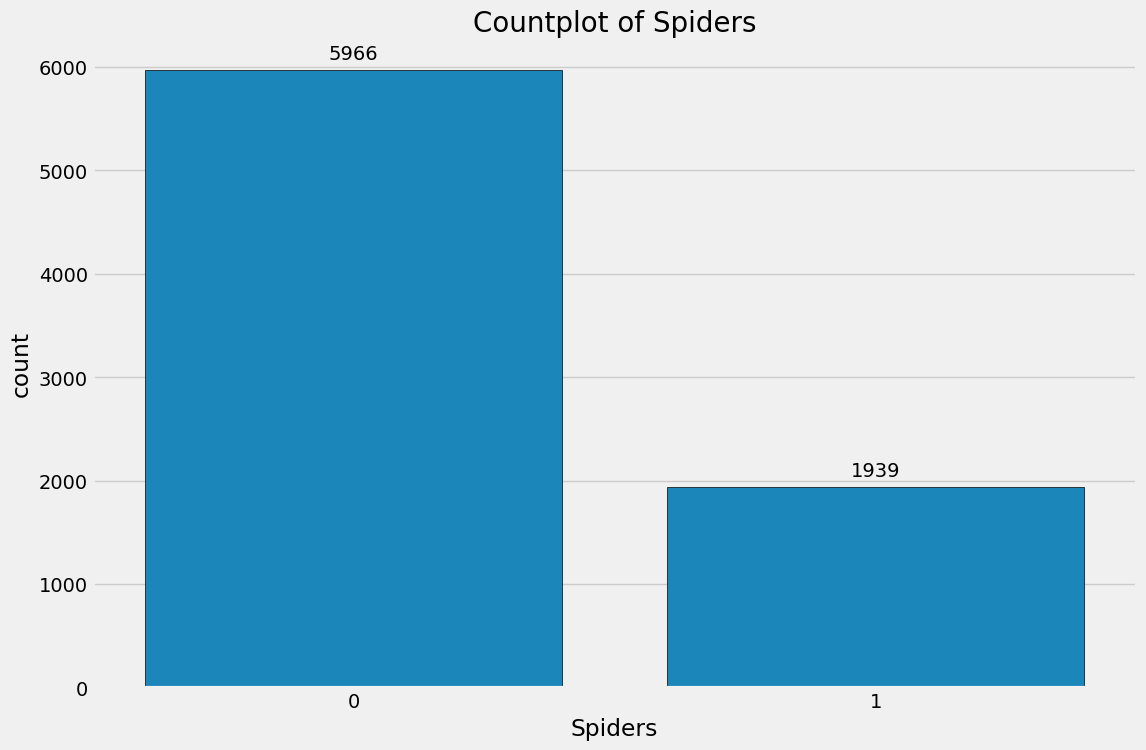

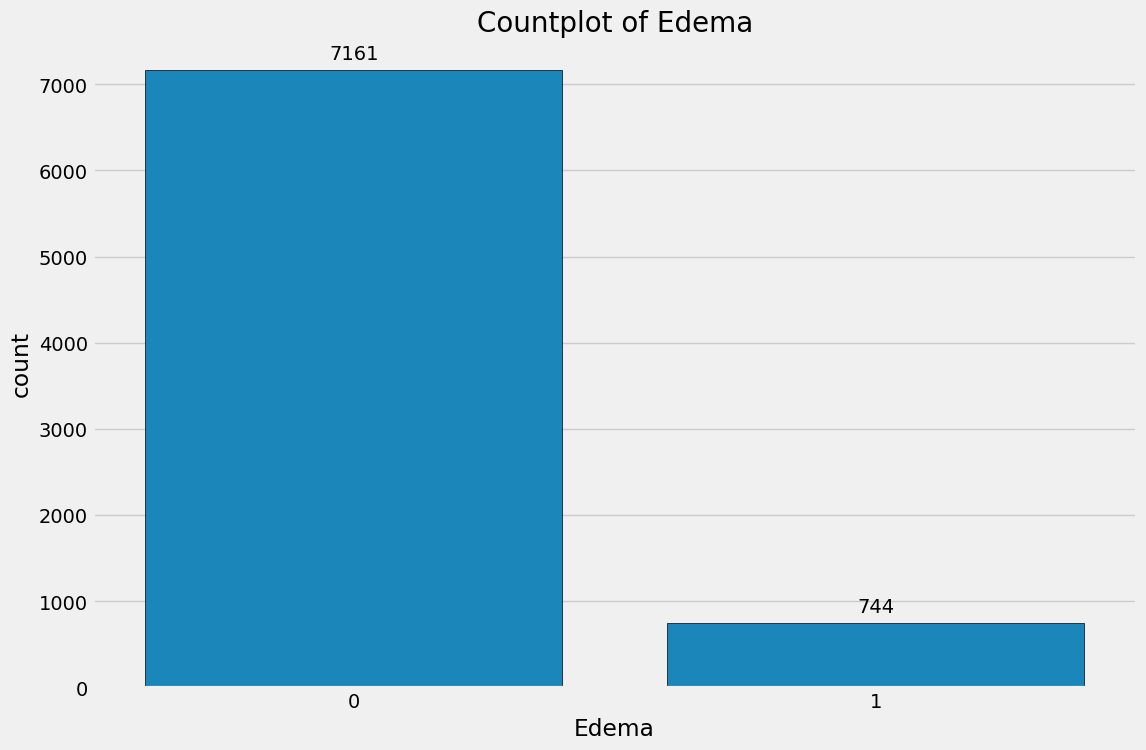

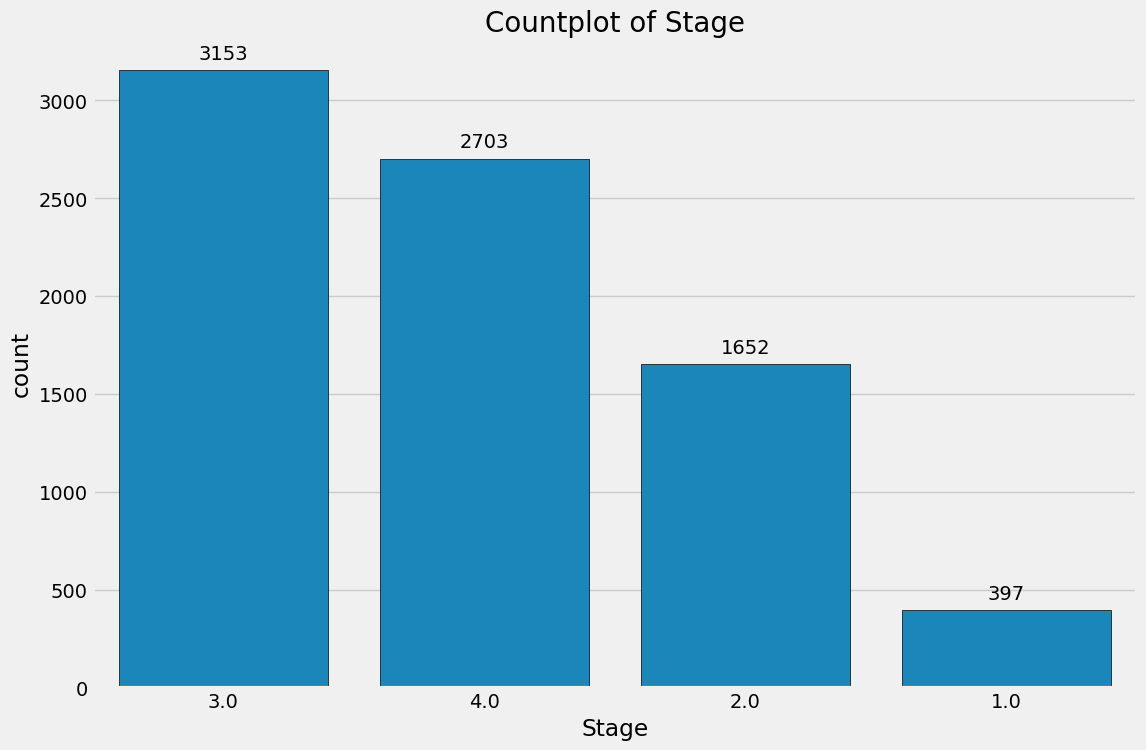

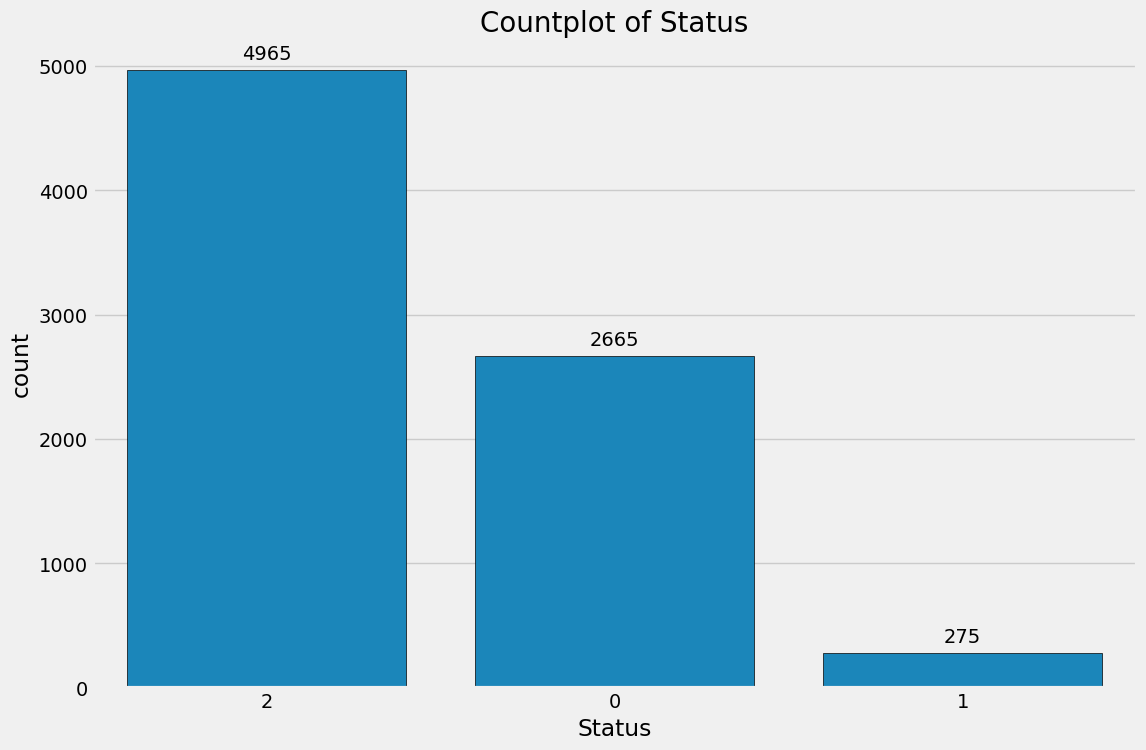

<Figure size 1200x800 with 0 Axes>

In [12]:
fast_eda(train, target = TARGET)

In [13]:
%%time
plot_tsne = TSNE().fit(train_tsne)

CPU times: total: 37.5 s
Wall time: 38.1 s


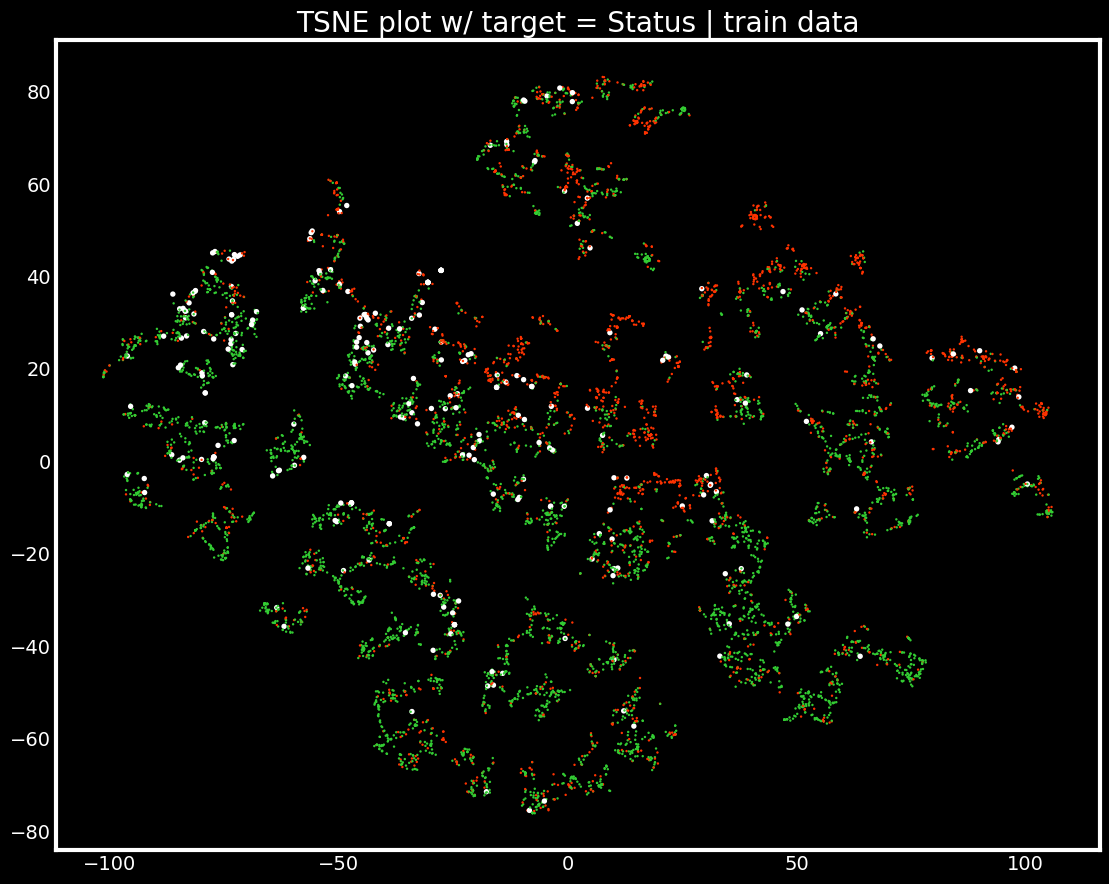

In [14]:
plt.style.use("dark_background")
plt.figure(figsize = (12, 10))

marker_sizes = [15 if hue == 1 else 3 for hue in y_tsne]

ax = sns.scatterplot(x = plot_tsne[:,0], y = plot_tsne[:,1], s = marker_sizes, hue = y_tsne,
                     linewidth = 0, palette = ["#ff3300", "#ffffff", "#33cc33"],
                     legend=False)
plt.grid(False)
plt.title(f"TSNE plot w/ target = {TARGET} | train data")
plt.show()

In [23]:
def train_model(train_data, model, features, n_splits, kfold_seed, include_orig):
    
    model_name = str(model).split("(")[0]
    test_preds = np.zeros((len(test), 3))
    oof_full = np.zeros((len(train_data), 3))
    val_scores, models = [], []
    
    print(model_name)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_seed)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=kfold_seed)
    
    for i, (train_idx, val_idx) in enumerate(tqdm(skf.split(train_data[features], train_data[TARGET]))):

        X_train, X_val = train_data[features].loc[train_idx], train_data[features].loc[val_idx]
        y_train, y_val = train_data[TARGET].loc[train_idx], train_data[TARGET].loc[val_idx]
        
        if include_orig:
            X_train = pd.concat([X_train, original[features]], ignore_index = True)
            y_train = pd.concat([y_train, original[TARGET]], ignore_index = True)
        
        if model_name in ["LGBMRegressor", "LGBMClassifier"]:
            callbacks = [early_stopping(stopping_rounds=50)]
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], callbacks=callbacks)
        elif model_name in ["XGBClassifier", "CatBoostClassifier"]:
            model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10000)
        else:
            model.fit(X_train, y_train)
        
        oof_preds = model.predict_proba(X_val[features])
        test_preds += model.predict_proba(test[features]) / n_splits
 
        oof_full[val_idx] = oof_preds
        score = log_loss(y_val, oof_preds)
        
        models.append(model)
        val_scores.append(score)
            
        print(f"{GREEN_TXT}FOLD {i + 1} log_loss: {round(score, 4)}{RESET_TXT}")
        
    print(f'{GREEN_TXT}mean log_loss across all folds: {np.mean(val_scores):.5f}{RESET_TXT}')
    print(f'{GREEN_TXT}std of log_loss across all folds: {np.std(val_scores):.5f}{RESET_TXT}')
    
    return oof_full, test_preds, models

In [16]:
xgb_params = {
    'objective': 'multi_logloss', 
    'max_depth': 9, 
    'learning_rate': 0.034869481921747415, 
    'n_estimators': 10000,
    'early_stopping_rounds': 50,
    'min_child_weight': 9, 
    'colsample_bytree': 0.2, 
    'reg_alpha': 0.10626128775335533, 
    'reg_lambda': 0.624196407787772, 
    'random_state': 42
}

lgb_params = {
    'objective': 'multi_logloss',
    'max_depth': 9,
    'min_child_samples': 14,
    'learning_rate': 0.034869481921747415,
    'n_estimators': 100000,
    'min_child_weight': 9,
    'colsample_bytree': 0.1702910221565107,
    'reg_alpha': 0.10626128775335533,
    'reg_lambda': 0.624196407787772,
    'random_state': 42
}

In [17]:
xgb_oof_preds, xgb_test_preds, xgb_models = train_model(
    train_data = train,
    model = XGBClassifier(**xgb_params),
    features = FEATURES,
    n_splits = 10,
    kfold_seed = 0,
    include_orig = True
)

XGBClassifier


0it [00:00, ?it/s]

[0]	validation_0-mlogloss:0.93459
[369]	validation_0-mlogloss:0.42464


1it [00:01,  1.96s/it]

FOLD 1 log_loss: 0.4237
[0]	validation_0-mlogloss:0.93467
[389]	validation_0-mlogloss:0.43365


2it [00:03,  1.74s/it]

FOLD 2 log_loss: 0.4322
[0]	validation_0-mlogloss:0.93504
[373]	validation_0-mlogloss:0.43539


3it [00:04,  1.57s/it]

FOLD 3 log_loss: 0.4338
[0]	validation_0-mlogloss:0.93452
[389]	validation_0-mlogloss:0.41653


4it [00:06,  1.59s/it]

FOLD 4 log_loss: 0.4158
[0]	validation_0-mlogloss:0.93503
[361]	validation_0-mlogloss:0.42070


5it [00:08,  1.56s/it]

FOLD 5 log_loss: 0.4202
[0]	validation_0-mlogloss:0.93399
[475]	validation_0-mlogloss:0.43816


6it [00:09,  1.63s/it]

FOLD 6 log_loss: 0.4368
[0]	validation_0-mlogloss:0.93387
[400]	validation_0-mlogloss:0.39889


7it [00:11,  1.59s/it]

FOLD 7 log_loss: 0.398
[0]	validation_0-mlogloss:0.93382
[405]	validation_0-mlogloss:0.42912


8it [00:12,  1.56s/it]

FOLD 8 log_loss: 0.4285
[0]	validation_0-mlogloss:0.93526
[373]	validation_0-mlogloss:0.44763


9it [00:14,  1.54s/it]

FOLD 9 log_loss: 0.4469
[0]	validation_0-mlogloss:0.93330
[361]	validation_0-mlogloss:0.42019


10it [00:16,  1.61s/it]

FOLD 10 log_loss: 0.4189
mean log_loss across all folds: 0.42547
std of log_loss across all folds: 0.01278


In [18]:
num_classes = train[TARGET].nunique()
lgb_params["num_class"] = num_classes
lgb_params["objective"] = "multiclass"
lgb_params["metric"] = "multi_logloss"

In [24]:
lgb_oof_preds, lgb_test_preds, lgb_models = train_model(
    train_data = train,
    model = LGBMClassifier(**lgb_params),
    features = FEATURES,
    n_splits = 10,
    kfold_seed = 0,
    include_orig = True
)

LGBMClassifier


0it [00:00, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 19
[LightGBM] [Info] Start training from score -1.079544
[LightGBM] [Info] Start training from score -3.321114
[LightGBM] [Info] Start training from score -0.471385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

1it [00:01,  1.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

2it [00:01,  1.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[290]	valid_0's multi_logloss: 0.430072
FOLD 2 log_loss: 0.4301
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of te

3it [00:02,  1.16it/s]

FOLD 3 log_loss: 0.4278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 19
[LightGBM] [Info] Start training from score -1.079544
[LightGBM] [Info] Start training from score -3.321114
[LightGBM] [Info] Start training from score -0.471385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

4it [00:03,  1.12it/s]

FOLD 4 log_loss: 0.409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1960
[LightGBM] [Info] Number of data points in the train set: 7532, number of used features: 19
[LightGBM] [Info] Start training from score -1.079544
[LightGBM] [Info] Start training from score -3.321114
[LightGBM] [Info] Start training from score -0.471385
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

5it [00:04,  1.05it/s]

FOLD 5 log_loss: 0.4166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1961
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 19
[LightGBM] [Info] Start training from score -1.079286
[LightGBM] [Info] Start training from score -3.317577
[LightGBM] [Info] Start training from score -0.471731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

6it [00:05,  1.09it/s]

FOLD 6 log_loss: 0.4377
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1957
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 19
[LightGBM] [Info] Start training from score -1.079286
[LightGBM] [Info] Start training from score -3.317577
[LightGBM] [Info] Start training from score -0.471731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

7it [00:06,  1.13it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

8it [00:07,  1.14it/s]

FOLD 8 log_loss: 0.4199
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1954
[LightGBM] [Info] Number of data points in the train set: 7533, number of used features: 19
[LightGBM] [Info] Start training from score -1.079286
[LightGBM] [Info] Start training from score -3.317577
[LightGBM] [Info] Start training from score -0.471731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

9it [00:07,  1.26it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

10it [00:08,  1.15it/s]

FOLD 10 log_loss: 0.4207
mean log_loss across all folds: 0.42182
std of log_loss across all folds: 0.01242


In [20]:
sub[f"{TARGET}_D"] =  xgb_test_preds[:, 0] * 0.5 + lgb_test_preds[:, 0] * 0.5
sub[f"{TARGET}_CL"] = xgb_test_preds[:, 1] * 0.5 + lgb_test_preds[:, 1] * 0.5
sub[f"{TARGET}_C"] =  xgb_test_preds[:, 2] * 0.5 + lgb_test_preds[:, 2] * 0.5
sub.head(3)

,id,Status_C,Status_CL,Status_D
0,7905,0.406282,0.034338,0.559380
1,7906,0.496059,0.231232,0.272709
2,7907,0.039749,0.012843,0.947407


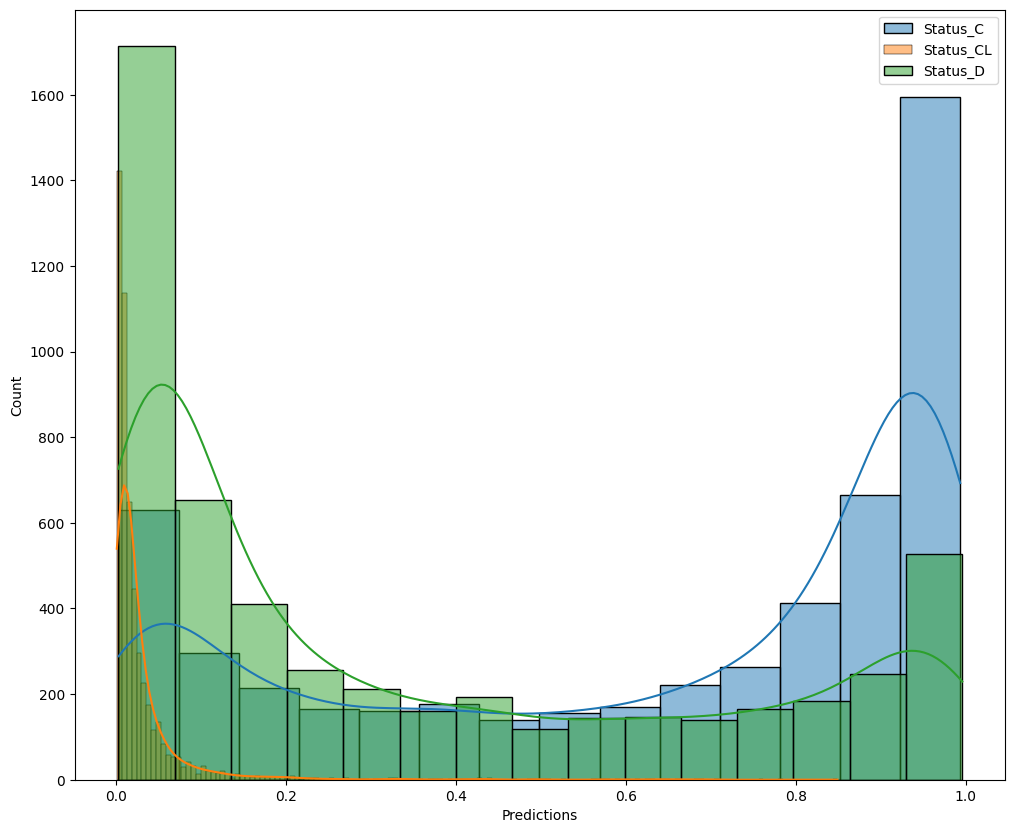

In [21]:
plt.style.use("default")
plt.figure(figsize = (12, 10))

sns.histplot(df, x = sub["Status_C"], kde = True, label = "Status_C")
sns.histplot(df, x = sub["Status_CL"], kde = True, label = "Status_CL")
sns.histplot(df, x = sub["Status_D"], kde = True, label = "Status_D")

plt.xlabel("Predictions")
plt.legend()
plt.show()

In [22]:
sub.to_csv("submission.csv", index = False)

# BAGGING STRATEGY WITH ORIGINAL DATASET INCLUDED IN TRAINING SET